## Disclaimer

This notebook is just me playing around with Corona data for my own entertainment. It is neither rigorous nor objective, and probably not very elegant, either. Please do not take any of these results for authoritative! Thank you :)

## Predicting Corona Cases by Nox Pollution

Corona cases are commonly modelled with a logistic model:

$$ n(t) = \alpha n(t) \left(1 - \frac{n(t)}{K} \right) $$

Where $n(t)$ is the number of infections at time $t$, $\alpha$ is the growth rate, and $K$ is the maximum number of people that can get infected.
Since 22.03.2020 a curfew has been put in place in bavaria. Additionally, people were asked to pay increased attention to hygiene and keep a safety distance to others. These measures have had an effect on $\alpha$, which means that $\alpha$ is now itself time-dependent:

$$ n(t) = \alpha(t) n(t) \left(1 - \frac{n(t)}{K} \right) $$

On Copernicus Hub, ESA makes data from the Sentinel 5P mission available, which measures $NO_x$ pollution in the atmosphere. If this data correlates with human transportation, it can be used to account for the effects of the curfew - the less travel, the more people adhere to the curfew. 

Let's assume we can calculate a measure of _connectivity_ $C_{x, y, t}$ between location $x$ and $y$ at time $t$ from the $NO_x$ data. ($C_{x, y, t}$ depends on $t$ because with the curfew people will travel less). Then we can explicitly integrate this connectivity in our growth formula:

$$ n(x, t) = \alpha(t) \left( \sum_y C_{y, x, t} n(y, t) \right) \left(1 - \frac{n(x, t)}{K} \right) $$

As an interesting side effect, with transportation explicitly accounted for, all changes to $\alpha$ must stem from the remaining measures, hygiene and distance.


### 0. Preparing data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as scpo
import shapely as sply

In [157]:
shps = gpd.read_file('./data/landkreise_risklayer.geojson')
shps = shps.rename(columns={'type': 'art', 'ags': 'AGS'})
shps['AGS'] = shps['AGS'].astype(np.int64)
vals = pd.read_csv('./data/values_landkreise_0904_no_ka.csv')

data = pd.merge(shps, vals, left_on='AGS', right_on='AGS', how='left')
data = data.set_index('name')

dateColNames = data.columns[6:-2]

In [162]:
bundeslaender = data[data.art == 'bundesland']
landkreise = data[data.art == 'landkreis']
landkreise[dateColNames] = landkreise[dateColNames].astype(np.int64)
bundeslaender[dateColNames] = landkreise.groupby('partof')[dateColNames].sum()
landkreise.current = landkreise.current.astype(np.int64)
bundeslaender.current = landkreise.groupby('partof').current.sum()

In [163]:
laenderNames = bundeslaender.index
laenderIds = np.arange(len(laenderNames))
bayernCuml = bundeslaender.loc['Bayern']
KBayern = bayernCuml['population'] * 0.7

In [164]:
landkreiseBayern = landkreise[landkreise.partof == 'Bayern']
landkreisNames = landkreiseBayern.index
landkreisIds = np.arange(len(landkreisNames))
population = landkreiseBayern['population'].values
Ks = landkreiseBayern['population'] * 0.7
T = len(dateColNames)
time = np.arange(T)
incubationTime = 7
tCurfew = list(dateColNames.values).index('22.03.2020')
tCurfewEffect = tCurfew + incubationTime

### 1. Simple model

As a sanity check, let's first fit an ordinary logistic model to our data.

In [165]:
def simpleModelBayern(alpha):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [166]:
def mseBayern(paras, model):
    y = bayernCuml[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim) * (y - y_sim))
    return me

In [167]:
resultsSimpleBayern = scpo.minimize(mseBayern, x0=[1.0], bounds=((0.01, 5.0),), args=(simpleModelBayern,))
resultsSimpleBayern

      fun: 18762305.58669573
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.11758709])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 7
   status: 0
  success: True
        x: array([0.19254503])

In [168]:
def plotSim(mod, paras):
    y = bayernCuml[dateColNames].values
    ySim = mod(*paras)
    plt.scatter(time, y)
    plt.plot(time, ySim)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

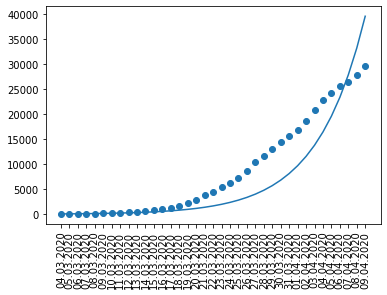

In [169]:
plotSim(simpleModelBayern, (resultsSimpleBayern.x,))

### 2. Allowing step in $\alpha$

In [170]:
def stepModelBayern(alpha0, alpha1):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [171]:
resultsStepBayern = scpo.minimize(mseBayern, x0=[1.0, 1.0], bounds=((0.01, 5.0), (0.01, 5.0)), args=(stepModelBayern,))
resultsStepBayern

      fun: 524229.7559124062
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-23.51007424,  -5.82658686])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 21
   status: 0
  success: True
        x: array([0.2378098 , 0.06946087])

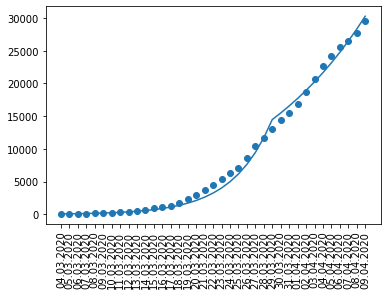

In [172]:
plotSim(stepModelBayern, resultsStepBayern.x)

### 3. Spatial model  (with toy-connectivity)

First, we need to calculate $C_{x, y, t}$. 
In the next section we'll use ESA's $NO_x$ data from Sentinel 5P, but as a simple stand-in, let's for now just assume that connectivity is inversely proportional to the squared distance:

$$ C_{x, y, t} \propto \frac{1}{d(x, y)^2} $$

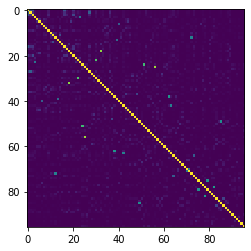

In [173]:
def calcConnectivity(n):
    centroids = landkreiseBayern.centroid
    centroids = centroids.to_crs('EPSG:25832')  # changing unit of distance to meters
    connectivity = np.zeros((len(landkreisNames), len(landkreisNames)), dtype=np.float64)
    for x in range(len(landkreisNames)):
        for y in range(x, len(landkreisNames)):
            lk1 = landkreiseBayern.index[x]
            lk2 = landkreiseBayern.index[y]
            distance10KM = centroids[lk1].distance(centroids[lk2]) / 10000
            c = 1.0 / ( 1 + distance10KM )**n
            connectivity[x, y] = c
            connectivity[y, x] = c
    return connectivity

tc = calcConnectivity(2)
plt.imshow(tc)

We can now make use of that connectivity in our model. Remember that $C_{x, y, t}$ is supposed to be time-dependent. In this simplified example, we just assume that $C$ is cut in half once the curfew is implemented. We'll make this more detailed once we work with actual $NO_x$ data.

In [174]:
def spatialModel(alpha0, alpha1, n):
    infected = np.zeros((len(landkreisIds), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values
    connectivity = calcConnectivity(n)
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        conct = connectivity if t < tCurfew else 0.5 * connectivity
        for landkreis in landkreisIds:
            K = Ks[landkreis]  # TODO: maybe K should be a spatially weighted sum, too?
            nc = np.inner( conct[landkreis, :], infected[:, t] )
            dndt = alpha * nc * (1 - infected[landkreis, t] / K)
            infected[landkreis, t+1] = infected[landkreis, t] + dndt
    return infected

In [175]:
def plotSimLks(mod, paras, lkName):
    y = landkreiseBayern[dateColNames].values
    ySim = mod(*paras)
    i = list(landkreiseBayern.index).index(lkName)
    plt.scatter(time, y[i])
    plt.plot(time, ySim[i])
    plt.title(lkName)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

In [176]:
def mseSpatial(paras, model):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim) * (y - y_sim))
    return me

In [177]:
resultsSpatial = scpo.minimize(mseSpatial, x0=[0.2, 0.1, 1.5], bounds=((0.001, 1), (0.001, 1), (1.0, 3.0)), args=(spatialModel,))
resultsSpatial

      fun: 21631.527985457982
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.97558324,  0.42236934, -0.0858563 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 168
      nit: 18
   status: 0
  success: True
        x: array([0.2062714 , 0.10728462, 2.9123404 ])

In [18]:
resultsSpatialBrute = scpo.brute(mseSpatial, ((0.00001, 2.0), (0.00001, 2.0), (0.001, 1.8)), args=(spatialModel,))
resultsSpatialBrute

KeyboardInterrupt: 

Let's look at how this model does for some Landkreise and globally.

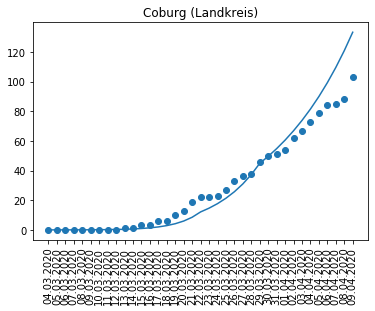

In [178]:
plotSimLks(spatialModel, resultsSpatial.x, 'Coburg (Landkreis)')

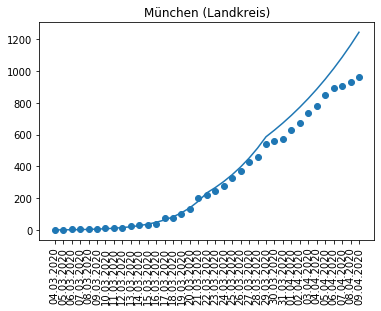

In [179]:
plotSimLks(spatialModel, resultsSpatial.x, 'München (Landkreis)')

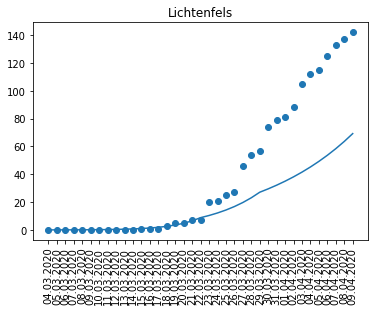

In [180]:
plotSimLks(spatialModel, resultsSpatial.x, 'Lichtenfels')

The simulations don't look decent for individual Landkreise, and they are good when cumulated:

In [181]:
y = landkreiseBayern[dateColNames].values
y_sim = spatialModel(*(resultsSpatial.x))
y_cuml = np.sum(y, axis=0)
y_sim_cuml = np.sum(y_sim, axis=0)

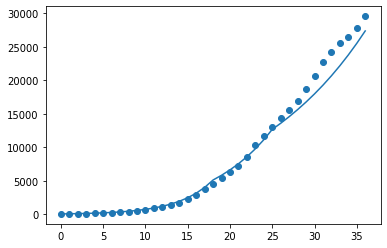

In [182]:
plt.scatter(time, y_cuml)
plt.plot(time, y_sim_cuml)

### 4. Spatial model (with actual $NO_x$ data)

We can assume that connectivity within a Landkreis - that is, $C_{x, x, t}$ - is proportional to the $NO_x$ within the bounds of that Landkreis.

It might make sense to assume the connectivity between Landkreise - $C_{x, y, t}, x \neq y$ - is proportional to the $NO_x$ between the center of one Landkreis and the center of another. But that would unintentionally include the traffic from the edges of a Landkreis to the center.

Instead, we'll overlay the borders of Landkreise with the routes of highways. These intersections are the points where traffic is going from one Landkreis to another. 